In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [2]:
def load_tif(filepath):
    """Load a single-band GeoTIFF file as a numpy array along with its metadata."""
    with rasterio.open(filepath) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
    return data, transform, crs

def save_tif(output_path, data, transform, crs):
    """Save a numpy array as a GeoTIFF file."""
    metadata = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'width': data.shape[1],
        'height': data.shape[0],
        'count': 1,
        'crs': crs,
        'transform': transform
    }
    with rasterio.open(output_path, 'w', **metadata) as dst:
        dst.write(data.astype('float32'), 1)
    print(f"Difference GeoTIFF saved to: {output_path}")

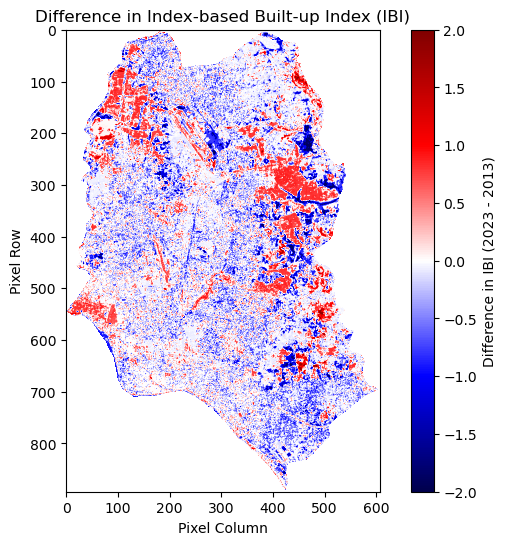

Difference GeoTIFF saved to: ./Landsat8/output/IBI_difference_2023_2013.tif


In [7]:
def compare_ibi(ibi_2013_path, ibi_2023_path, output_path=None):
    """
    Compare two IBI GeoTIFF files and visualize the difference.
    
    Parameters:
    - ibi_2013_path: Path to the IBI GeoTIFF for 2013.
    - ibi_2023_path: Path to the IBI GeoTIFF for 2023.
    - output_path: Path to save the difference GeoTIFF (optional).
    """
    # Load the IBI data for both years
    ibi_2013, transform, crs = load_tif(ibi_2013_path)
    ibi_2023, _, _ = load_tif(ibi_2023_path)

    # Calculate the difference
    ibi_difference = ibi_2023 - ibi_2013

    # Visualize the difference
    plt.figure(figsize=(8, 6))
    plt.imshow(ibi_difference, cmap="seismic", vmin=-2, vmax=2)
    plt.colorbar(label="Difference in IBI (2023 - 2013)")
    plt.title("Difference in Index-based Built-up Index (IBI)")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()

    # Save the difference GeoTIFF if an output path is provided
    if output_path:
        save_tif(output_path, ibi_difference, transform, crs)

# Paths to the IBI GeoTIFF files
ibi_2013_path = "./Landsat8/output/2013/IBI_2013.tif"
ibi_2023_path = "./Landsat8/output/2023/IBI_2023.tif"

# Output path for the difference GeoTIFF
output_difference_path = "./Landsat8/output/IBI_difference_2023_2013.tif"

# Compare IBI and save the difference
compare_ibi(ibi_2013_path, ibi_2023_path, output_difference_path)